### imports

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [170]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor ,BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from xgboost import XGBRegressor   

In [4]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
from dask_ml.model_selection import RandomizedSearchCV
from dask.distributed import Client

### Data preparation

- read the csv files

In [7]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
features = pd.read_csv('data/features.csv')

#### Data preprocessing and data engineering

- **Chaining method** using `pipe`for data preprocessing and engineering  which includes:
    - convert date to datetime format
    - merging train/test with features and store
    - create column of week, month and quarter
    - one-hot-encoding for `type` (converting from categorical to numeric)
    - convert `is_holiday` from boolean to numeric (1 for true, 0 for false)
    - frop `isholday` as its redundant
    - assign a new column of `ID` as shown in sampleSubmission.csv
    - set date as index

In [92]:
merged_train = (
    train
    .pipe(lambda df: df.assign(date=pd.to_datetime(df['date'])))               # Convert date to datetime
    .merge(
        features.pipe(lambda df: df.assign(date=pd.to_datetime(df['date']))),  # Convert and merge features
        on=["store", "date"],
        how="inner"
    )
    .merge(stores, on="store", how="inner")                # Merge stores data
    .assign(
        Week=lambda df: df['date'].dt.isocalendar().week,  # Add Week column
        Month=lambda df: df['date'].dt.month,              # Add Month column
        Quarter=lambda df: df['date'].dt.quarter           # Add Quarter column
    )
    .pipe(lambda df: df.assign(IsHoliday=df['is_holiday'].map({'f': 0, 't': 1})))  # Label Encoding for is_holiday 
    .pipe(pd.get_dummies, columns=['type'], prefix='type')
    .drop(columns=['isholiday'], errors='ignore')         # Drop isholiday
    .assign(ID=lambda df: df['store'].astype(str) + '_' + df['dept'].astype(str))  # Create Store_Dept
    .set_index('date')                                    # Set date as index
)

merged_test = (
    test
    .pipe(lambda df: df.assign(date=pd.to_datetime(df['date'])))               # Convert date to datetime
    .merge(
        features.pipe(lambda df: df.assign(date=pd.to_datetime(df['date']))),  # Convert and merge features
        on=["store", "date"],
        how="inner",
        suffixes=('', '_features')
    )
    .merge(stores, on="store", how="inner")                # Merge stores data
    .assign(
        Week=lambda df: df['date'].dt.isocalendar().week,  # Add Week column
        Month=lambda df: df['date'].dt.month,              # Add Month column
        Quarter=lambda df: df['date'].dt.quarter           # Add Quarter column
    )
    .pipe(lambda df: df.assign(IsHoliday=df['isholiday'].map({'f': 0, 't': 1})))  # Label Encoding for is_holiday
    .pipe(pd.get_dummies, columns=['type'], prefix='type')
    .drop(columns=['isholiday'], errors='ignore')         # Drop is holiday
    .assign(ID=lambda df: df['store'].astype(str) + '_' + df['dept'].astype(str))  # Create Store_Dept
    .set_index('date')                                    # Set date as index
)


- Check the shape for consistent data set

In [93]:
print(f"Initial train data shape :{train.shape}")
print(f"Initial test data shape :{test.shape}")
print(f"Merged train data shape :{merged_train.shape}")
print(f"Merged test data shape :{merged_test.shape}")

Initial train data shape :(421570, 5)
Initial test data shape :(115064, 4)
Merged train data shape :(421570, 22)
Merged test data shape :(115064, 21)


- check for any missing values

In [86]:
train_missing = merged_train[merged_train.isna().any(axis=1)]
print(f"Number of missing rows in train: {len(train_missing)}")

test_missing = merged_test[merged_test.isna().any(axis=1)]
print(f"Number of missing rows in train: {len(test_missing)}")

Number of missing rows in train: 0
Number of missing rows in train: 0


- check for any duplicates

In [11]:
duplicate_train = merged_train[merged_train.duplicated()]
duplicate_test = merged_test[merged_test.duplicated()]

print(f"Number of duplicate rows in train: {len(duplicate_train)}")
print(f"Number of duplicate rows in test: {len(duplicate_test)}")

Number of duplicate rows in train: 0
Number of duplicate rows in test: 0


### Exploratory Data Analysis (EDA)

#### Summary Statistics

In [15]:
merged_train.head(5)

,store,dept,weekly_sales,is_holiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,...,unemployment,size,Week,Month,Quarter,IsHoliday,type_A,type_B,type_C,ID
date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,f,42.31,2.572,0.0,0.0,0.0,0.0,...,8.106,151315,5,2,1,0,True,False,False,1_1
2010-02-12,1,1,46039.49,t,38.51,2.548,0.0,0.0,0.0,0.0,...,8.106,151315,6,2,1,1,True,False,False,1_1
2010-02-19,1,1,41595.55,f,39.93,2.514,0.0,0.0,0.0,0.0,...,8.106,151315,7,2,1,0,True,False,False,1_1
2010-02-26,1,1,19403.54,f,46.63,2.561,0.0,0.0,0.0,0.0,...,8.106,151315,8,2,1,0,True,False,False,1_1
2010-03-05,1,1,21827.90,f,46.50,2.625,0.0,0.0,0.0,0.0,...,8.106,151315,9,3,1,0,True,False,False,1_1


In [16]:
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2011-12-23
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store         421570 non-null  int64  
 1   dept          421570 non-null  int64  
 2   weekly_sales  421570 non-null  float64
 3   is_holiday    421570 non-null  object 
 4   temperature   421570 non-null  float64
 5   fuel_price    421570 non-null  float64
 6   markdown1     421570 non-null  float64
 7   markdown2     421570 non-null  float64
 8   markdown3     421570 non-null  float64
 9   markdown4     421570 non-null  float64
 10  markdown5     421570 non-null  float64
 11  cpi           421570 non-null  float64
 12  unemployment  421570 non-null  float64
 13  size          421570 non-null  int64  
 14  Week          421570 non-null  UInt32 
 15  Month         421570 non-null  int32  
 16  Quarter       421570 non-null  int32  
 17  IsHoliday     421570 non-null  i

In [17]:
merged_train.describe

<bound method NDFrame.describe of             store  dept  weekly_sales is_holiday  temperature  fuel_price  \
date                                                                        
2010-02-05      1     1   24924.50000          f        42.31       2.572   
2010-02-12      1     1   46039.49000          t        38.51       2.548   
2010-02-19      1     1   41595.55000          f        39.93       2.514   
2010-02-26      1     1   19403.54000          f        46.63       2.561   
2010-03-05      1     1   21827.90000          f        46.50       2.625   
...           ...   ...           ...        ...          ...         ...   
2011-12-23     45     7   15981.46725          f        42.27       3.389   
2010-11-26     45    72   15981.46725          t        46.15       3.039   
2010-12-24     45    72   15981.46725          f        30.59       3.141   
2011-11-25     45    72   15981.46725          t        48.71       3.492   
2011-12-23     45    72   15981.46725     

#### Time Series Analysis

- Monthly and Quarterly Sales

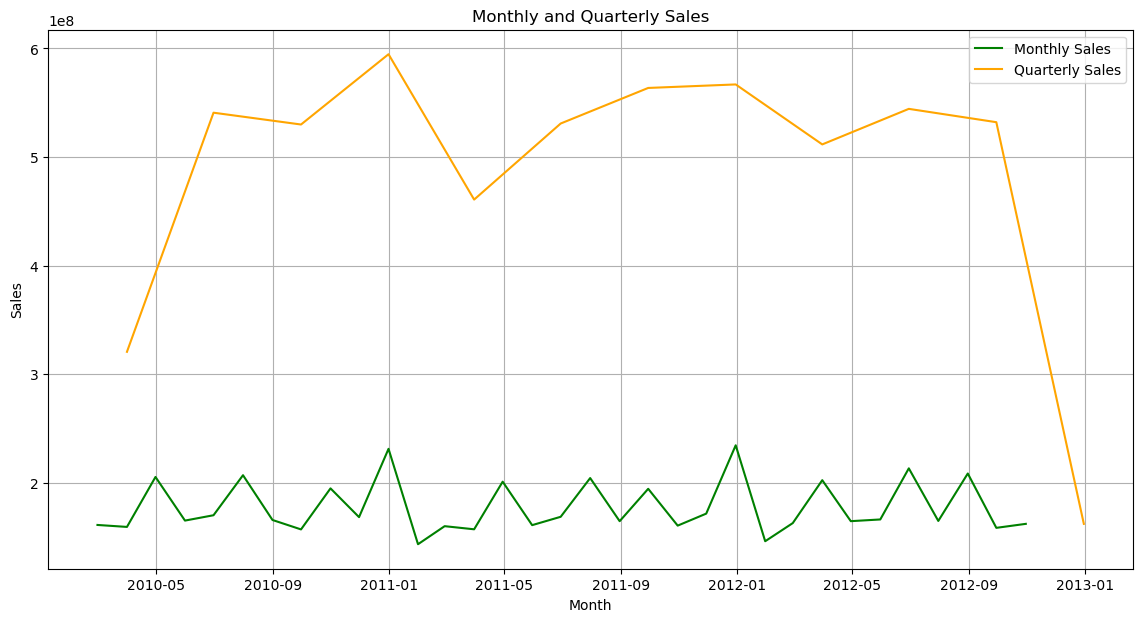

In [19]:
monthly_sales = merged_train.resample('M')['weekly_sales'].sum()
quarterly_sales = merged_train.resample('Q')['weekly_sales'].sum()

# Plot monthly and quarterly sales
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales, label='Monthly Sales', color='green')
plt.plot(quarterly_sales.index, quarterly_sales, label='Quarterly Sales', color='orange')
plt.title('Monthly and Quarterly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True);


- **rolling mean** is used to smooth out spikes and fluctuations.

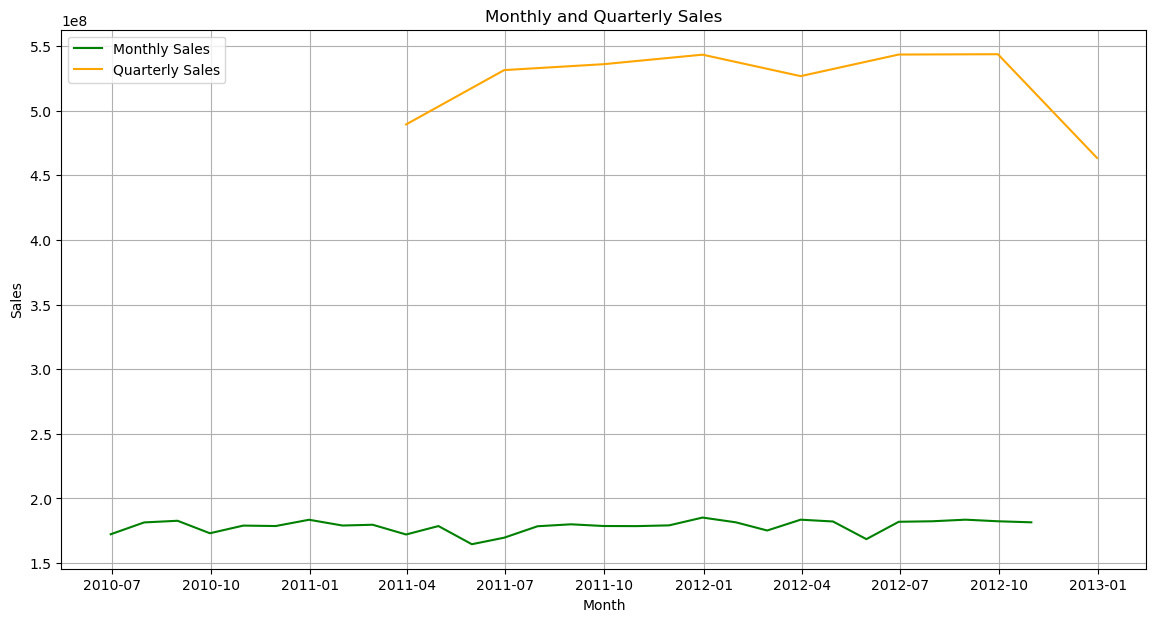

In [21]:

monthly_sales = merged_train.resample('M')['weekly_sales'].sum().rolling(window=5).mean()
quarterly_sales = merged_train.resample('Q')['weekly_sales'].sum().rolling(window=5).mean()

# Plot monthly and quarterly sales
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales, label='Monthly Sales', color='green')
plt.plot(quarterly_sales.index, quarterly_sales, label='Quarterly Sales', color='orange')
plt.title('Monthly and Quarterly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True);


**Analysis**
- January 2011 has the highest sales
- Monthly Sales are quite even (do not fluatuate much) overall
- There is a drastic drop in the fourth quarter (Q4) of 2013 as the data set is until the last week of October, hence the drop of sales at this quarter will be ignored.

<hr>

#### Weekly Sales Distributions

- Histogram of Sales

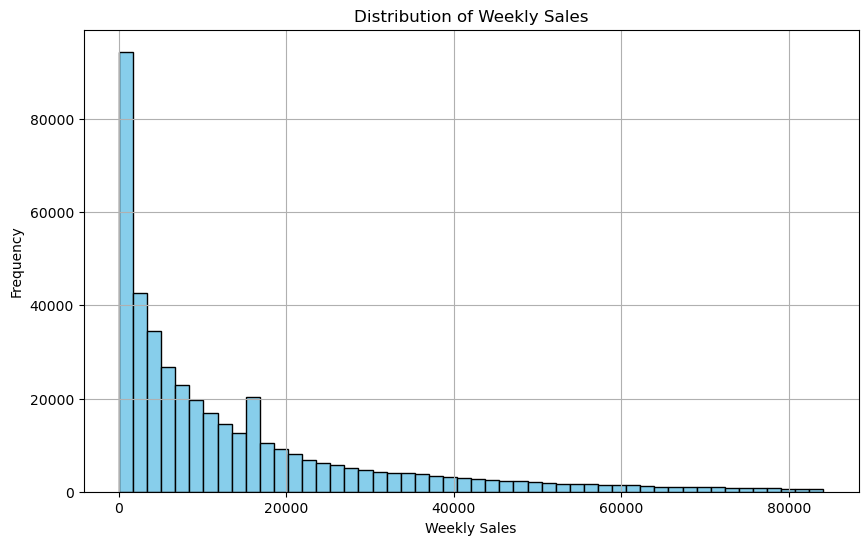

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(merged_train['weekly_sales'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.grid(True);

**Analysis**
- Obviously a 0 weekly sales has the highest frequency
- The histogram is right skewed
- The higher the weekly sales, the lesser the chances (low frequency)

<hr>

#### Sales affected by features

##### Weekly Sales affected by Fuel Price

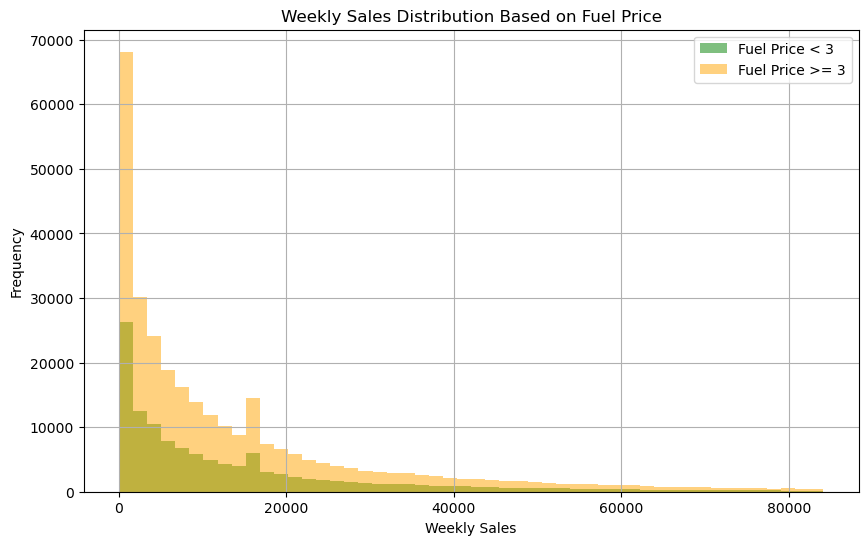

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(merged_train['weekly_sales'][merged_train['fuel_price'] < 3], bins=50, alpha=0.5, label='Fuel Price < 3', color='green')
plt.hist(merged_train['weekly_sales'][merged_train['fuel_price'] >= 3], bins=50, alpha=0.5, label='Fuel Price >= 3', color='orange')
plt.title('Weekly Sales Distribution Based on Fuel Price')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True);

**Analysis**
- Fuel Price more or equal than 3 has higher weekly sales frequency overall
- More developed country are more likely to have higher fuel price, resulting in the greater purchase capability of people to contribute to higher sales

<hr>

##### Weekly Sales affectted by holiday

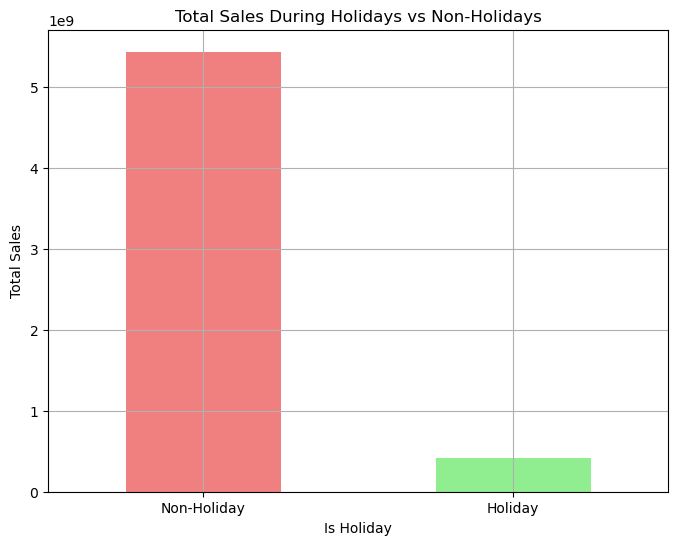

In [28]:
sales_by_holiday = merged_train.groupby('IsHoliday')['weekly_sales'].sum()

plt.figure(figsize=(8, 6))
sales_by_holiday.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Total Sales During Holidays vs Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Total Sales')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'], rotation=0)
plt.grid(True);

**Analysis**
- Non-Holiday has significantly higher sales than holiday
- Stores may have closed during holidays.

<hr>

##### Weekly Sales affected by size, stores and department

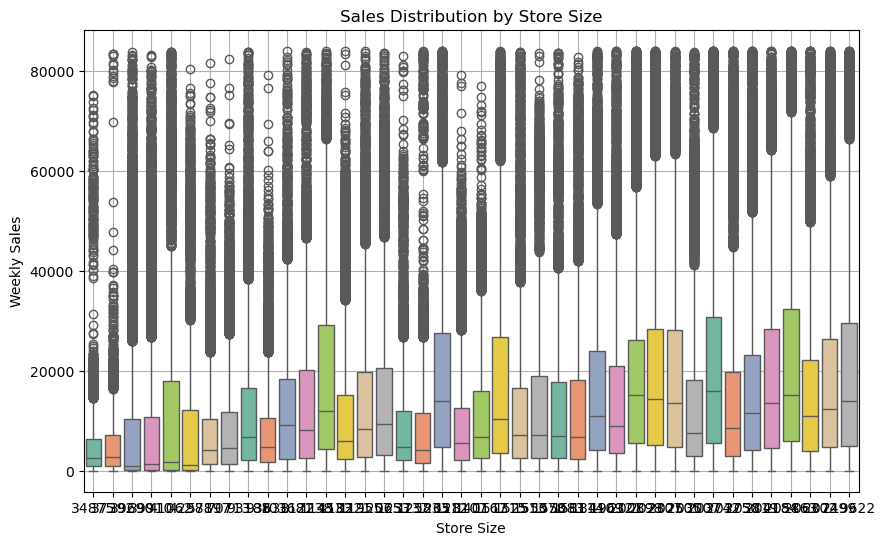

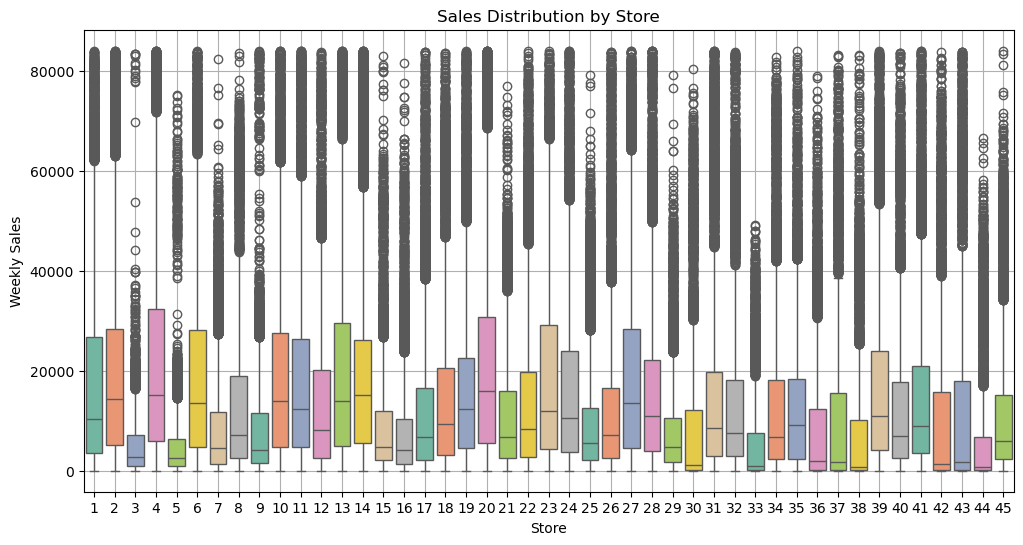

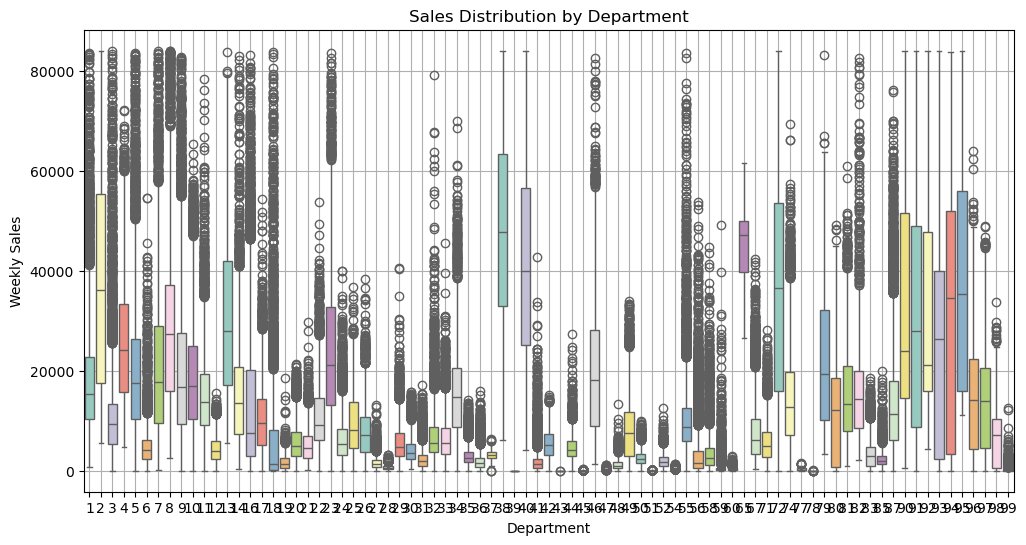

In [31]:
# Boxplot for size
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_train['size'], y=merged_train['weekly_sales'], palette='Set2')
plt.title('Sales Distribution by Store Size')
plt.xlabel('Store Size')
plt.ylabel('Weekly Sales')
plt.grid(True);

# Boxplot for stores 
plt.figure(figsize=(12, 6))
sns.boxplot(x='store', y='weekly_sales', data=merged_train, palette='Set2')
plt.title('Sales Distribution by Store')
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.grid(True);

# Boxplot for departments 
plt.figure(figsize=(12, 6))
sns.boxplot(x='dept', y='weekly_sales', data=merged_train, palette='Set3')
plt.title('Sales Distribution by Department')
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()


**No Obvious Trends Observed**

<hr>

##### Weekly Sales affected by Store Types

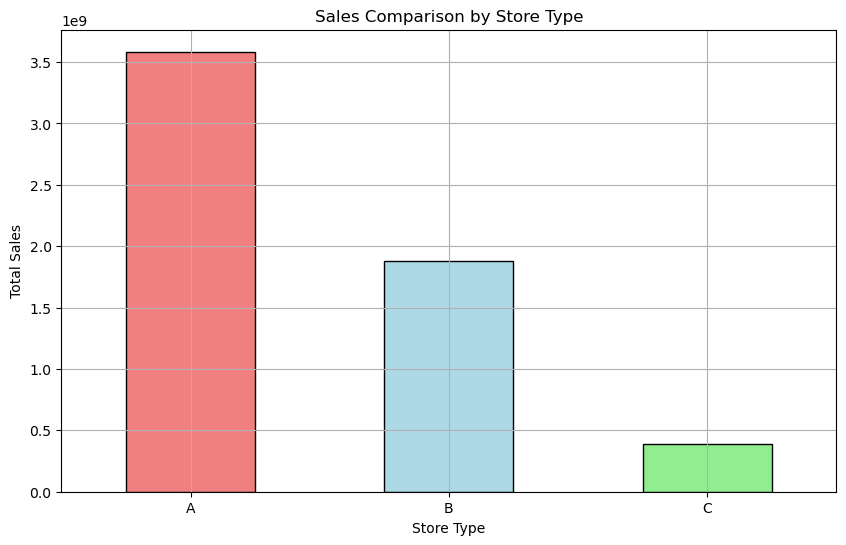

In [34]:
sales_by_store_type = merged_train.groupby(['type_A', 'type_B', 'type_C'])['weekly_sales'].sum()
sales_by_store_type = sales_by_store_type.reset_index()

sales_by_store_type['store_type'] = sales_by_store_type.apply(lambda x: 'A' if x['type_A'] == 1 else ('B' if x['type_B'] == 1 else 'C'), axis=1)
sales_by_store_type = sales_by_store_type.groupby('store_type')['weekly_sales'].sum()

plt.figure(figsize=(10, 6))
sales_by_store_type.plot(kind='bar', color=['lightcoral', 'lightblue', 'lightgreen'], edgecolor='black')
plt.title('Sales Comparison by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.grid(True);


**Analysis**
- The sales is highest in store type A, followed by type B and the lowest is store type C

<hr>

### Features Importance and Selection

- Create a `Pearson Correlation Heatmap` to inspect on initial correlation between variables

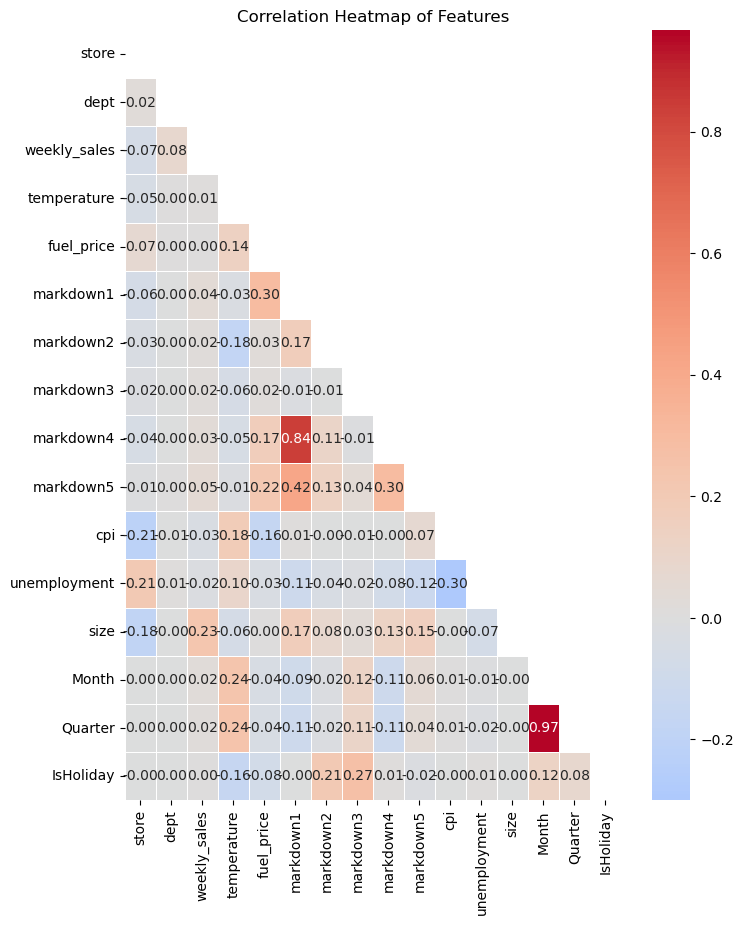

In [234]:
corrs = merged_train.select_dtypes(include=['int','float']).corr()

filtered_corrs = corrs.where(np.abs(corrs)>0 )
mask = np.triu(np.ones_like(filtered_corrs, dtype=bool))

plt.figure(figsize=(8, 10))
sns.heatmap(filtered_corrs, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5, cbar=True, mask=mask)
plt.title('Correlation Heatmap of Features');

**Analysis:**
- seems like only size has a significant relationship with weekly_sales

#### Lasso Regularisation

- we use lasso to find important features **(as many features are irrelevant)**
- Lasso can perform features selection

Selected Features by Lasso Regularization:
         Feature  Coefficient
0          store  -534.653398
1           dept  1290.348258
2    temperature   473.549563
3     fuel_price  -190.253080
4      markdown1    -0.046099
5      markdown2    13.398472
6      markdown3   187.209852
7      markdown4    36.219541
8      markdown5   223.251106
9            cpi  -738.330702
10  unemployment  -178.116252
11          size  3767.389460
12         Month   834.703960
13       Quarter  -635.693209
14     IsHoliday    31.252134


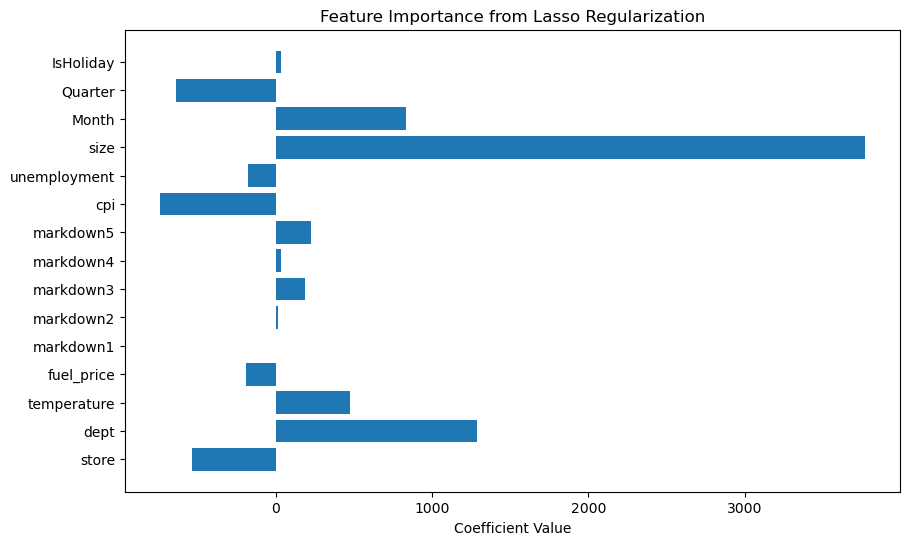

In [70]:
# Find categorical and numeric columns
categorical_cols = ['is_holiday']  
numeric_cols = merged_train.select_dtypes(include=['float', 'int']).drop(columns=['weekly_sales',]).columns

# Transform to numeric
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),                # Scale numeric columns (store and dept)
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  # OneHotEncode categorical columns (type)
    ]
)

# Training and testing data split
X = merged_train.drop(columns=['weekly_sales'])  
y = merged_train['weekly_sales']
X_preprocessed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=13)

lasso = LassoCV(cv=5, random_state=13)
lasso.fit(X_train, y_train)

# Find coefficients
coefficients = lasso.coef_
encoded_feature_names = (
    list(numeric_cols) +  
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()
)

feature_importance = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Coefficient': coefficients
})

# Filter features with non-zero coefficients
selected_features = feature_importance[feature_importance['Coefficient'] != 0]
print("Selected Features by Lasso Regularization:")
print(selected_features)

# Features importance plot
plt.figure(figsize=(10, 6))
plt.barh(selected_features['Feature'], selected_features['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance from Lasso Regularization');

### Evaluation function 

- We are using **weighted mean absolute error (WMAE)**

In [71]:
def calculate_wmae(y_true, y_pred, is_holiday):
    """
    Function to calculate the WMAE

    Parameters:
    y_true: Actual sales 
    y_pred: Predicted sales
    is_holiday : Holiday week or otherwise

    Ouput:
    float: WMAE
    """
    # Weightage of 5 for holiday weeks, 1 otherwise
    weights = np.where(is_holiday == 1, 5, 1)
    
    # Compute the absolute error
    absolute_error = np.abs(y_true - y_pred)
    
    # Compute the WMAE
    wmae = np.sum(weights * absolute_error) / np.sum(weights)
    
    return wmae

### Machine learning & Predictions

- Data preparation with the features importance that we found using lasso

In [94]:
train_features = selected_features['Feature']
# Define X and y
X = merged_train[train_features]
X.loc[:, 'IsHoliday'] = X['IsHoliday'].astype(int)  
y = merged_train['weekly_sales']

# Save the 'IsHoliday' column before scaling for wmae calculation
X_features = X.drop(columns='IsHoliday') 
is_holiday_column = X['IsHoliday']  

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Convert scaled features back to DataFrame and reset index
X_scaled_df = pd.DataFrame(X_scaled, columns=X_features.columns)
X_scaled_df = X_scaled_df.reset_index(drop=True)
X_scaled_df['IsHoliday'] = is_holiday_column.reset_index(drop=True)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=13)


#### Simple modeling

##### Linear Regression

In [95]:
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predictions
y_pred = lm.predict(X_test)

# Calculate WMAE
is_holiday_test = X_test['IsHoliday']
wmae = calculate_wmae(y_test, y_pred, is_holiday_test)
print(f"Weighted Mean Absolute Error (WMAE): {wmae}")

Weighted Mean Absolute Error (WMAE): 11829.132977802426


- Predictions using `merged_test`

In [186]:
# Define the features to use for forecasting (same as training, excluding 'ID' and 'IsHoliday')
X_test_merged = merged_test[train_features]

# Drop 'ID' and 'IsHoliday' columns only if they exist in X_test_merged
columns_to_drop = ['ID', 'IsHoliday']
X_test_merged = X_test_merged.drop(columns=[col for col in columns_to_drop if col in X_test_merged.columns])

# Scale the features using the same scaler used in training
X_test_scaled_merged = scaler.transform(X_test_merged)

# Convert the scaled data back to DataFrame and re-include 'IsHoliday'
X_test_scaled_merged = pd.DataFrame(X_test_scaled_merged, columns=X_test_merged.columns)
X_test_scaled_merged['IsHoliday'] = merged_test['IsHoliday'].reset_index(drop=True)

# Make predictions using the trained Linear Regression model
y_pred_merged = lm.predict(X_test_scaled_merged)
print(y_pred_merged)


[13210.4096611  13564.13996443 13336.79984523 ... 18341.31616069
 18320.21929929 18160.28811855]


In [98]:
merged_test['date'] = merged_test.index   # will increase one column in testing dataset

submission = pd.DataFrame({
    'Id': merged_test['ID'],
    'Weekly_Sales': y_pred_merged  
})

submission.head()
# submission.to_csv('submission.csv', index=False)


,Id,Weekly_Sales
date,,
2012-11-02,1_1,13210.409661
2012-11-09,1_1,13564.139964
2012-11-16,1_1,13336.799845
2012-11-23,1_1,15840.988689
2012-11-30,1_1,13512.628864


##### Random Forest Regression

In [62]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

# Predictions
y_pred_rfr = rfr.predict(X_test)


# Calculate WMAE
is_holiday_test = X_test['IsHoliday']
wmae = calculate_wmae(y_test, y_pred_rfr, is_holiday_test)
print(f"Weighted Mean Absolute Error (WMAE): {wmae}")

Weighted Mean Absolute Error (WMAE): 1903.2222779874696


- Predictions using `merged_test`

In [107]:
# Define the features to use for forecasting (same as training, excluding 'ID' and 'IsHoliday')
X_test_rfr = merged_test[train_features]

# Drop 'ID' and 'IsHoliday' columns only if they exist in X_test_merged
columns_to_drop = ['ID', 'IsHoliday']
X_test_rfr = X_test_rfr.drop(columns=[col for col in columns_to_drop if col in X_test_rfr.columns])

# Scale the features using the same scaler used in training
X_test_scaled_rfr = scaler.transform(X_test_rfr)

# Convert the scaled data back to DataFrame and re-include 'IsHoliday'
X_test_scaled_rfr = pd.DataFrame(X_test_scaled_rfr, columns=X_test_merged.columns)
X_test_scaled_rfr['IsHoliday'] = merged_test['IsHoliday'].reset_index(drop=True)

# Make predictions using the trained Random Forest model
y_pred_merged_rfr = rfr.predict(X_test_scaled_rfr)
print(y_pred_merged_rfr)


[21264.9769725 20549.2286    20872.4489    ...   958.4011      970.63
   964.5822   ]


In [112]:
rfr_forecast_df = merged_test[['ID', 'date']].copy()

# Assign the forecast values directly
rfr_forecast_df['Weekly_Sales'] = y_pred_merged_rfr
rfr_forecast_df.head()


,ID,date,Weekly_Sales
date,,,
2012-11-02,1_1,2012-11-02,21264.976973
2012-11-09,1_1,2012-11-09,20549.228600
2012-11-16,1_1,2012-11-16,20872.448900
2012-11-23,1_1,2012-11-23,21494.863400
2012-11-30,1_1,2012-11-30,23240.706573


In [113]:
rfr_forecast_df['ID'] = (
    rfr_forecast_df['ID'].astype(str) + "_" +
    rfr_forecast_df['date'].astype(str)
)

# Select only 'ID' and 'Weekly_Sales' columns
submission_rfr = rfr_forecast_df[['ID', 'Weekly_Sales']]

submission_rfr.head()

,ID,Weekly_Sales
date,,
2012-11-02,1_1_2012-11-02,21264.976973
2012-11-09,1_1_2012-11-09,20549.228600
2012-11-16,1_1_2012-11-16,20872.448900
2012-11-23,1_1_2012-11-23,21494.863400
2012-11-30,1_1_2012-11-30,23240.706573


##### Boosting

- We are using `XGBoost` for efficiency.

In [69]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)

# Calculate WMAE
is_holiday_test = X_test['IsHoliday']
wmae = calculate_wmae(y_test, y_pred_xgb, is_holiday_test)
print(f"Weighted Mean Absolute Error (WMAE): {wmae}")


Weighted Mean Absolute Error (WMAE): 4205.050774848015


#### Statistical model

##### ARIMA model

- We have to determine the most important features for ARIMA model first which are:
    - p: the number of autoregressive terms
    - d: degree of differencing
    - q: number of moving average

<hr>

Check stationarity using `ADF test` to find the d value

In [80]:

merged_train.index = pd.to_datetime(merged_train.index)
monthly_sales = merged_train.groupby(pd.Grouper(freq='M'))['weekly_sales'].sum().reset_index()

def test_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print("The time series is stationary")
    else:
        print("The time series is not stationary, differencing required")

test_stationarity(monthly_sales['weekly_sales'])



ADF Statistic: -7.194403438654826
p-value: 2.455972571062197e-10
The time series is stationary


<hr>

Proceed with ACF and PACF plot to find **p** and **q**

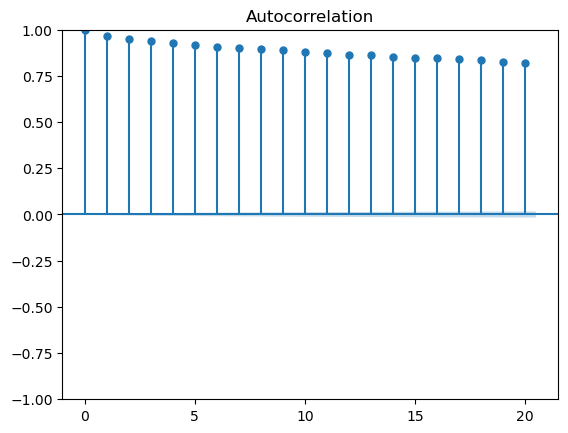

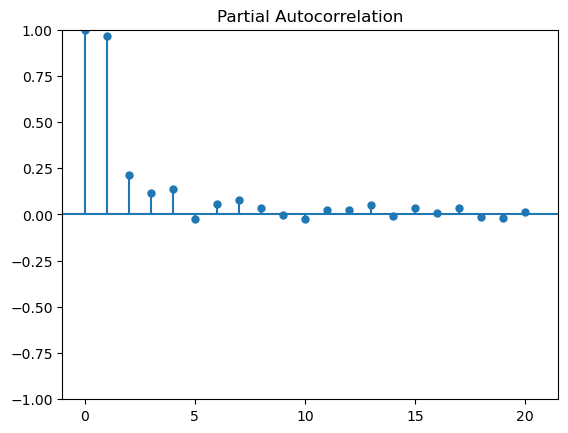

In [29]:
plot_acf(merged_train['weekly_sales'].dropna(), lags=20)
plot_pacf(merged_train['weekly_sales'].dropna(), lags=20)
plt.show()

- **Significant spikes** are in:

    -  lag 0 for ACF plot as there are no significant spikes
    -  lag 1 for PACF plot
-  the value of **q** will be **0** and **p** will be **1**
<hr>

Fit the model

In [127]:
ari_model = ARIMA(merged_train['weekly_sales'], order=(1, 0, 0))  
ari = ari_model.fit()
ari.summary()

c:\Users\ckcho\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ckcho\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ckcho\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ckcho\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ckcho\anaconda3\Lib\site-

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           weekly_sales   No. Observations:               421570
Model:                 ARIMA(1, 0, 0)   Log Likelihood            -4112049.047
Date:                Mon, 23 Dec 2024   AIC                        8224104.094
Time:                        15:24:41   BIC                        8224136.950
Sample:                             0   HQIC                       8224113.462
                             - 421570                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.39e+04    295.805     46.981      0.000    1.33e+04    1.45e+04
ar.L1          0.9684      0.000   3538.907      0.000       0.968       0.969
sigma2      1.737e+07      5.838   2.98e+06      0.000    1.74e+07    1.74e+07
===================================================================================
Ljung-Box (L1) (Q):               17660.52   Jarque-Bera (JB):          48826805.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.95e+19. Standard errors may be unstable.
"""

- Predictions using `merged_test`

In [128]:
# Forecast for the test set
n_forecasts = len(merged_test)  # Number of forecasts needed
ari_forecast = ari.forecast(steps=n_forecasts)

# Reset the index 
ari_forecast = ari.forecast(steps=n_forecasts)
ari_forecast_df = merged_test[['store', 'dept', 'ID', 'date']].copy()

# Assign the forecast values directly
ari_forecast_df['Weekly_Sales'] = ari_forecast.values
ari_forecast_df.head()


c:\Users\ckcho\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ckcho\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,store,dept,ID,date,Weekly_Sales
date,,,,,
2012-11-02,1,1,1_1,2012-11-02,15915.582808
2012-11-09,1,1,1_1,2012-11-09,15851.781072
2012-11-16,1,1,1_1,2012-11-16,15789.996206
2012-11-23,1,1,1_1,2012-11-23,15730.164452
2012-11-30,1,1,1_1,2012-11-30,15672.224071


In [129]:
ari_forecast_df['ID'] = (
    ari_forecast_df['ID'].astype(str) + "_" +
    ari_forecast_df['date'].astype(str)
)

# Select only 'ID' and 'Weekly_Sales' columns
submission_ari = ari_forecast_df[['ID', 'Weekly_Sales']]

submission_ari.head()

,ID,Weekly_Sales
date,,
2012-11-02,1_1_2012-11-02,15915.582808
2012-11-09,1_1_2012-11-09,15851.781072
2012-11-16,1_1_2012-11-16,15789.996206
2012-11-23,1_1_2012-11-23,15730.164452
2012-11-30,1_1_2012-11-30,15672.224071


- model evaluation

In [152]:
n_forecasts_evaluate = len(X_test)
ari_forecast_evaluate = ari.forecast(steps=n_forecasts_evaluate)
ari_forecast_array = ari_forecast_evaluate.to_numpy()

c:\Users\ckcho\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [154]:
# Calculate WMAE
is_holiday_ari = X_test['IsHoliday']
wmae_ari = calculate_wmae(y_test, ari_forecast_array, is_holiday_ari)
print(f"Weighted Mean Absolute Error (WMAE): {wmae_ari}")

Weighted Mean Absolute Error (WMAE): 12282.87958654475


##### SARIMAX model

- We perform some **hyperparameter tuning** to build the sarimax model by tuning the time series (seasonally)

In [121]:
merged_train.index = pd.to_datetime(merged_train.index)
monthly_sales_ari = merged_train.groupby(pd.Grouper(freq='M'))['weekly_sales'].sum().reset_index()


auto_model = auto_arima(
    monthly_sales_ari['weekly_sales'],
    seasonal=False,
    m=52,  
    stepwise=True,
    trace=True
)

auto_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1349.894, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1256.781, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1332.564, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1229.979, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1227.623, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1226.438, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1227.729, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=1227.129, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1213.593, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1212.413, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   33
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -600.983
Date:                Mon, 23 Dec 2024   AIC                           1209.966
Time:                        15:16:36   BIC                           1215.952
Sample:                             0   HQIC                          1211.980
                                 - 33                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.737e+08   5.15e-10   7.25e+17      0.000    3.74e+08    3.74e+08
ar.L1         -0.6521      0.124     -5.238      0.000      -0.896      -0.408
ar.L2         -0.4434      0.114     -3.877      0.000      -0.668      -0.219
sigma2      3.772e+14   1.17e-16   3.22e+30      0.000    3.77e+14    3.77e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.29
Prob(Q):                              0.88   Prob(JB):                         0.04
Heteroskedasticity (H):               0.98   Skew:                             0.76
Prob(H) (two-sided):                  0.97   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.25e+46. Standard errors may be unstable.
"""

In [122]:
sarima_model = SARIMAX(
    merged_train['weekly_sales'],
    order=(auto_model.order),
    seasonal_order=(auto_model.seasonal_order),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit()
sarima_result.summary()

c:\Users\ckcho\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ckcho\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ckcho\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ckcho\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           weekly_sales   No. Observations:               421570
Model:               SARIMAX(2, 0, 0)   Log Likelihood            -4103274.806
Date:                Mon, 23 Dec 2024   AIC                        8206555.612
Time:                        15:17:15   BIC                        8206588.467
Sample:                             0   HQIC                       8206564.979
                             - 421570                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7688      0.000   1709.586      0.000       0.768       0.770
ar.L2          0.2165      0.000    452.429      0.000       0.216       0.217
sigma2      1.667e+07   5.29e-12   3.15e+18      0.000    1.67e+07    1.67e+07
===================================================================================
Ljung-Box (L1) (Q):                 337.46   Jarque-Bera (JB):          50429481.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        56.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.38e+32. Standard errors may be unstable.
"""

- Predictions using `merged_test`

In [123]:
n_forecasts = len(merged_test)

sarima_forecast = sarima_result.forecast(steps=n_forecasts)

sarima_forecast_df = merged_test[['store', 'dept', 'date']].copy()
sarima_forecast_df['Weekly_Sales'] = sarima_forecast.values



sarima_forecast_df['ID'] = (
    sarima_forecast_df['store'].astype(str) + "_" +
    sarima_forecast_df['dept'].astype(str) + "_" +
    sarima_forecast_df['date'].astype(str)
)

submission_df_sarima = sarima_forecast_df[['ID', 'Weekly_Sales']]
submission_df_sarima
# submission_df.to_csv('submission.csv', index=False)



c:\Users\ckcho\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,ID,Weekly_Sales
date,,
2012-11-02,1_1_2012-11-02,1.574744e+04
2012-11-09,1_1_2012-11-09,1.556751e+04
2012-11-16,1_1_2012-11-16,1.537850e+04
2012-11-23,1_1_2012-11-23,1.519423e+04
2012-11-30,1_1_2012-11-30,1.501163e+04
...,...,...
2013-06-28,45_98_2013-06-28,3.310240e-322
2013-07-05,45_98_2013-07-05,3.310240e-322
2013-07-12,45_98_2013-07-12,3.310240e-322


- Model evaluation

In [143]:
n_forecasts_evaluate = len(X_test)
sarima_forecast_evaluate = sarima_result.forecast(steps=n_forecasts_evaluate)
sarima_forecast_array = sarima_forecast_evaluate.to_numpy()


c:\Users\ckcho\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [145]:
# Calculate WMAE
is_holiday_sarima = X_test['IsHoliday']
wmae_sarima = calculate_wmae(y_test, sarima_forecast_array, is_holiday_sarima)
print(f"Weighted Mean Absolute Error (WMAE): {wmae_sarima}")

Weighted Mean Absolute Error (WMAE): 13850.928770835837


#### Deep learning

##### Long Short term Memory Networks (LSTM)

**Below code may take more than 30 mins to run!!!**

In [57]:
# Scaling
scaler = MinMaxScaler()
X_train_scaled_lstm = scaler.fit_transform(X_train)
X_test_scaled_lstm = scaler.transform(X_test)

# Reshaping
X_train_lstm = np.reshape(X_train_scaled_lstm, (X_train_scaled_lstm.shape[0], 1, X_train_scaled_lstm.shape[1]))
X_test_lstm = np.reshape(X_test_scaled_lstm, (X_test_scaled_lstm.shape[0], 1, X_test_scaled_lstm.shape[1]))

# LSTM model
advanced_lstm_model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled_lstm.shape[1])),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile model
advanced_lstm_model.compile(optimizer='adam', loss='mae')

# Add early stopping (we have too many epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = advanced_lstm_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Predictions
y_pred_lstm2 = advanced_lstm_model.predict(X_test_lstm)



Epoch 1/100
4216/4216 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 11422.5332 - val_loss: 10824.4697
Epoch 2/100
4216/4216 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 10803.2998 - val_loss: 9682.0518
Epoch 3/100
4216/4216 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 9819.8262 - val_loss: 9304.2744
Epoch 4/100
4216/4216 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 9577.7617 - val_loss: 9238.2432
Epoch 5/100
4216/4216 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 9452.3154 - val_loss: 9187.6758
Epoch 6/100
4216/4216 ━━━━━━━━━━━━━━━━━━━━ 65s 15ms/step - loss: 9383.6836 - val_loss: 9156.3779
Epoch 7/100
4216/4216 ━━━━━━━━━━━━━━━━━━━━ 65s 15ms/step - loss: 9250.3623 - val_loss: 9105.9619
Epoch 8/100
4216/4216 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 9201.3643 - val_loss: 9041.3535
Epoch 9/100
4216/4216 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 9203.5410 - val_loss: 8988.6992
Epoch 10/100
4216/4216 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 9158.0020 - val_loss: 8942.3760
Epoch 11/100
4216/4216 ━━━━━━━━━━

- model evaluation

In [58]:
# wmae
is_holiday_test = X_test['IsHoliday']
y_pred_lstm2_flat = y_pred_lstm2.flatten()

wmae = calculate_wmae(y_test, y_pred_lstm2_flat, is_holiday_test)
print(f"Weighted Mean Absolute Error (WMAE): {wmae}")

Weighted Mean Absolute Error (WMAE): 7660.469058541813


- Predictions using `merged_test`

In [190]:
# Select the same features used during training
X_test_merged = merged_test[train_features]  

columns_to_drop = ['ID', 'IsHoliday']
X_test_merged = X_test_merged.drop(columns=[col for col in columns_to_drop if col in X_test_merged.columns])

# Scale the features using the same scaler used in training
X_test_scaled_merged = scaler.transform(X_test_merged)

# Convert the scaled data back to DataFrame and re-include 'IsHoliday'
X_test_scaled_merged = pd.DataFrame(X_test_scaled_merged, columns=X_test_merged.columns)
X_test_scaled_merged['IsHoliday'] = merged_test['IsHoliday'].reset_index(drop=True)

# Reshape the data for LSTM input (important to make it a tensor)
X_test_merged_lstm = np.reshape(X_test_scaled_merged, (X_test_scaled_merged.shape[0], 1, X_test_scaled_merged.shape[1]))

# Predict
y_pred_merged_lstm = advanced_lstm_model.predict(X_test_merged_lstm)
y_pred_merged_lstm_flat = y_pred_merged_lstm.flatten() # important to make it back to 2 dimension


3596/3596 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [196]:
lstm_forecast_df = merged_test[['store', 'dept', 'ID', 'date']].copy()
lstm_forecast_df['Weekly_Sales'] = y_pred_merged_lstm_flat

lstm_forecast_df['ID'] = (
    lstm_forecast_df['ID'].astype(str) + "_" +
    lstm_forecast_df['date'].astype(str)
)

submission_df_sarima = lstm_forecast_df[['ID', 'Weekly_Sales']]
submission_df_sarima

,ID,Weekly_Sales
date,,
2012-11-02,1_1_2012-11-02,203126.265625
2012-11-09,1_1_2012-11-09,184886.984375
2012-11-16,1_1_2012-11-16,189213.312500
2012-11-23,1_1_2012-11-23,239330.109375
2012-11-30,1_1_2012-11-30,237245.671875
...,...,...
2013-06-28,45_98_2013-06-28,71267.195312
2013-07-05,45_98_2013-07-05,75613.632812
2013-07-12,45_98_2013-07-12,73316.179688


#### Final model and predictions submission

##### Stacking model

- We will be stacking the models with the best performance (smallest wmae) together as a stacking model
- THe models stacked will be `RandomForestRegression`, `ARIMA` and `LSTM` model
- `Ridge regression` is used as **meta learner**

In [174]:
# Stack
train_meta_features = np.vstack((y_pred_rfr, y_pred_lstm2_flat, ari_forecast_array)).T
val_meta_features = np.vstack((y_pred_rfr, y_pred_lstm2_flat, ari_forecast_array)).T


# Train on Ridge (linear)
meta_learner = Ridge(alpha=1.0)
meta_learner.fit(train_meta_features, y_test)
y_pred_stacking = meta_learner.predict(val_meta_features)


#  WMAE
is_holiday_stack = X_test['IsHoliday']
wmae_stack = calculate_wmae(y_test, y_pred_stacking, is_holiday_stack)
print(f"Weighted Mean Absolute Error (WMAE): {wmae_stack}")

Weighted Mean Absolute Error (WMAE): 1918.7711370406066


**Predictions using `merged_test`**

In [204]:
test_meta_features = np.vstack((y_pred_merged_rfr, y_pred_merged_lstm_flat, ari_forecast)).T
y_pred_stacking_test = meta_learner.predict(test_meta_features)
y_pred_stacking_test

array([26031.66373287, 24905.96548602, 25297.11634573, ...,
        2524.4662621 ,  2589.6397346 ,  2505.21245142])

In [205]:
stack_forecast_df = merged_test[['store', 'dept', 'ID', 'date']].copy()
stack_forecast_df['Weekly_Sales'] = y_pred_stacking_test

stack_forecast_df['ID'] = (
    stack_forecast_df['ID'].astype(str) + "_" +
    stack_forecast_df['date'].astype(str)
)

submission_df_stack = stack_forecast_df[['ID', 'Weekly_Sales']]
submission_df_stack

,ID,Weekly_Sales
date,,
2012-11-02,1_1_2012-11-02,26031.663733
2012-11-09,1_1_2012-11-09,24905.965486
2012-11-16,1_1_2012-11-16,25297.116346
2012-11-23,1_1_2012-11-23,26987.332381
2012-11-30,1_1_2012-11-30,28637.543502
...,...,...
2013-06-28,45_98_2013-06-28,2470.587386
2013-07-05,45_98_2013-07-05,2581.450320
2013-07-12,45_98_2013-07-12,2524.466262


#### Key insights 

##### Selected model and export

- After testing on various model, the most suitable model will be <u>the stacking model</u>
- This model stacks on `RandomForestRegression`, `ARIMA` and `LSTM` model
- Finally, export out predictions as `final_submission.csv`

In [207]:
submission_df_stack.to_csv('final_submission.csv', index=False)

In [211]:
print(merged_test.shape)
print(merged_train.shape) 

(115064, 22)
(421570, 22)


##### Forecasting visualization

In [ ]:
monthly_sales = merged_train.resample('M')['weekly_sales'].sum()
quarterly_sales = merged_train.resample('Q')['weekly_sales'].sum()

# Plot monthly and quarterly sales
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales, label='Monthly Sales', color='green')
plt.plot(quarterly_sales.index, quarterly_sales, label='Quarterly Sales', color='orange')
plt.title('Monthly and Quarterly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True);


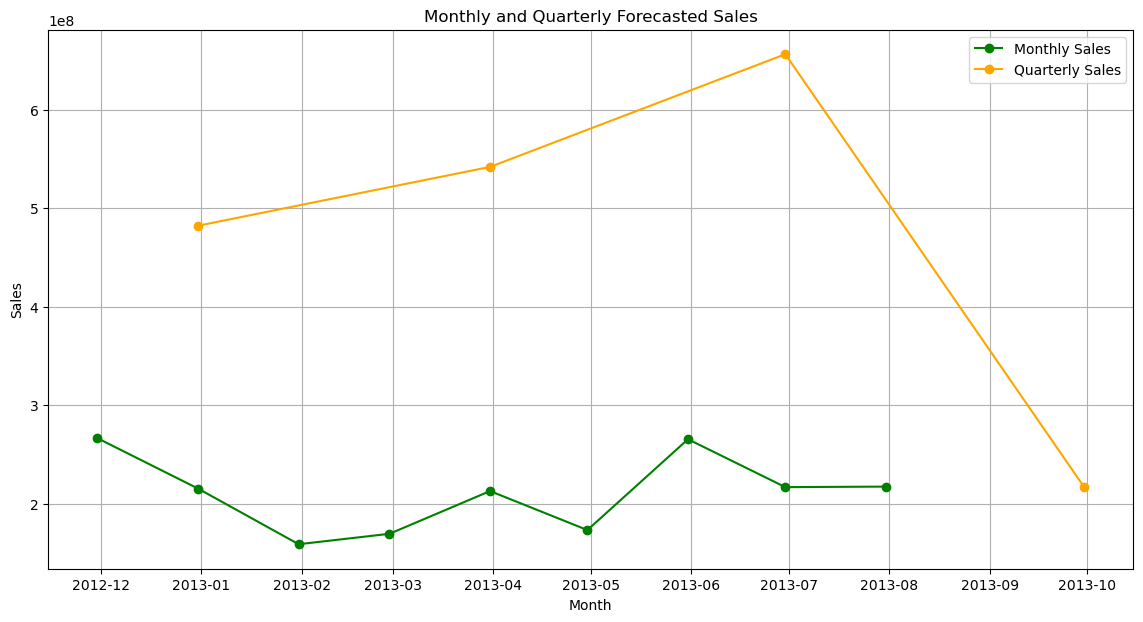

In [231]:
forecast_visual_df = merged_test[['store', 'dept', 'ID', 'date']].copy()
forecast_visual_df['Weekly_Sales'] = y_pred_stacking_test

# Resampling
monthly_forecast_sales = forecast_visual_df.resample('M')['Weekly_Sales'].sum()
quarterly_forecast_sales = forecast_visual_df.resample('Q')['Weekly_Sales'].sum()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(monthly_forecast_sales.index, monthly_forecast_sales, label='Monthly Sales', color='green',marker='o')
plt.plot(quarterly_forecast_sales.index, quarterly_forecast_sales, label='Quarterly Sales', color='orange', marker='o')
plt.title('Monthly and Quarterly Forecasted Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True);


##### Recommendation

- It is observed that the **third quarter (Q3)** of 2013 has the **highest** sales, while the **first quarter (Q1)** is the **lowest**, which corresponds to **February 2013**.
- There is a drastic drop of sales in the **fourth quarter (Q4)** as the testing dataset is until the **last week of July**, thus **Q4 sales** is being **ignored**
<br>

- It is recommended to **organise promotions** in **February 2013** to boost the sales when the sales is forecasted to be at its lowest.
- Moreover, it is recommended to invest in **more employees and stocks** in **December 2012 and June 2013** when the sales is forecasted to be the highest, where there are more customers which needs more stocks and labor.

<hr>